# Function 2: 2D Mystery ML Model

*Analogy: Tuning a simple machine learning model to maximize its log-likelihood score.*

### Characteristics

* Noisy: "Each output is noisy." The observed $y$ varies ($y + \epsilon$). Querying $(x_1, x_2)$ twice yields different results.

* Landscape: "Complex functions with many local peaks." There is a high risk of getting stuck in a local optimum.

* Strategy: Requires balancing exploration (checking new areas) vs exploitation (refining known good spots) to handle noise.

## 1. Setup and load data (read-only from initial_data)

In [50]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")


# Project root: works whether you run from repo root or from notebooks/
repo_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

from src.utils.load_challenge_data import (
    load_function_data, 
    assert_not_under_initial_data
)
from src.optimizers.bayesian.acquisition_functions import (
    entropy_search,
    expected_improvement,
    probability_of_improvement,
    thompson_sampling_sample,
    upper_confidence_bound,
)
from src.utils.plot_utilities import (
    add_colorbar,
    style_axis,
    style_axis_3d,
    style_legend,
    DEFAULT_FONT_SIZE_AXIS,
    DEFAULT_FONT_SIZE_TITLES,
    DEFAULT_EXPORT_DPI,
    DEFAULT_EXPORT_FORMAT,
)

# --- Plot options; font/export defaults from utils (DEFAULT_*) ---
IF_SHOW_PLOT = True
IF_EXPORT_PLOT = True
PLOT_EXPORT_DIR = repo_root / "data" / "results"

IF_EXPORT_QUERIES = True
IF_APPEND_DATA = False

# Set seed for reproducibility
np.random.seed(42)

In [51]:
# Load: prefer local appended data (inputs.npy/outputs.npy), else initial local copy, else initial_data (read-only)
local_dir = repo_root / "data" / "problems" / "function_2"
local_inputs = local_dir / "inputs.npy"
local_outputs = local_dir / "outputs.npy"
if local_inputs.exists() and local_outputs.exists():
    X = np.load(local_inputs)
    y = np.load(local_outputs)
    if y.ndim > 1:
        y = y.squeeze()
    print("Loaded from local data (initial + appended):", local_dir)
else:
    local_inputs = local_dir / "initial_inputs.npy"
    local_outputs = local_dir / "initial_outputs.npy"
    if local_inputs.exists() and local_outputs.exists():
        X = np.load(local_inputs)
        y = np.load(local_outputs)
        if y.ndim > 1:
            y = y.squeeze()
        print("Loaded from local data (initial):", local_dir)
    else:
        X, y = load_function_data(function_id=2)
        print("Loaded from initial_data (read-only). Run 'Append data' after portal feedback to build local dataset.")

print('Dataset info:')
print('Location of the dataset: ', local_dir)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X max value: {X.max():.6f}")
print(f"X min value: {X.min():.6f}")
print(f"y max value: {y.max():.6f}")
print(f"y min value: {y.min():.6f}")

Loaded from initial_data (read-only). Run 'Append data' after portal feedback to build local dataset.
Dataset info:
Location of the dataset:  /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/problems/function_2
X shape: (10, 2)
y shape: (10,)
X max value: 0.926564
X min value: 0.028698
y max value: 0.611205
y min value: -0.065624


## 2. Visualize the initial points

Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_2_observations_and_distance_contour.png
Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_2_3d_surface_y_colour.png


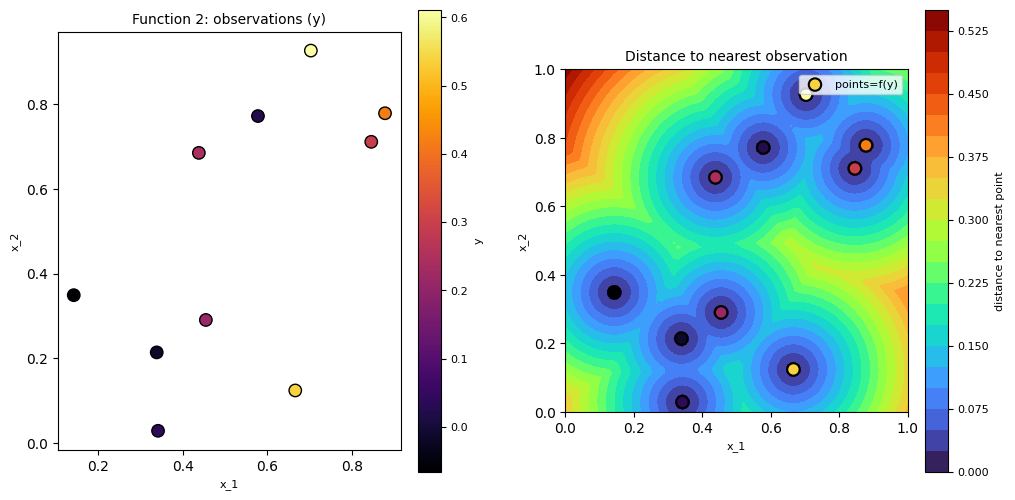

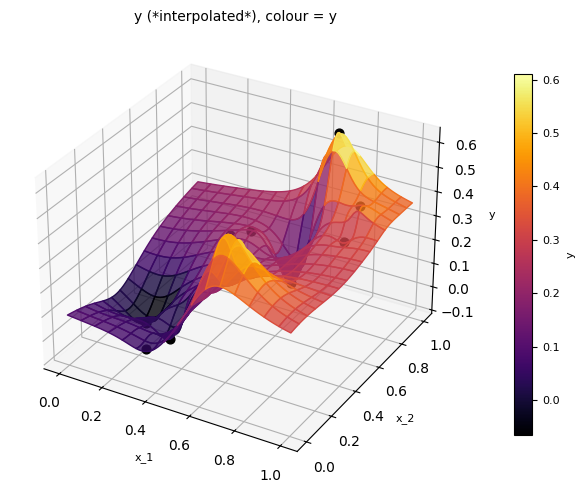

In [52]:
# Grid for contour: distance from each point to nearest observation
n_grid = 80
x1g = np.linspace(0, 1, n_grid)
x2g = np.linspace(0, 1, n_grid)
X1g, X2g = np.meshgrid(x1g, x2g)
grid_pts = np.column_stack([X1g.ravel(), X2g.ravel()])
# Distance from each grid point to nearest of X (L2, numpy only)
diff = grid_pts[:, None, :] - X[None, :, :]  # (n_grid^2, n_obs, 2)
dists = np.sqrt((diff ** 2).sum(axis=2))
min_dist = np.min(dists, axis=1).reshape(X1g.shape)

# Interpolate y onto grid (IDW) for 3D surface
dist_gx = np.sqrt(((grid_pts[:, None, :] - X[None, :, :]) ** 2).sum(axis=2)) + 1e-12
w = 1.0 / (dist_gx ** 2)
y_grid = (w * y[None, :]).sum(axis=1) / w.sum(axis=1)
Y_grid = y_grid.reshape(X1g.shape)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# Left: scatter of observations colored by y
sc = ax1.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap="inferno", edgecolors="k")
add_colorbar(sc, ax=ax1, label="y", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
style_axis(ax1, xlabel="x_1", ylabel="x_2", title="Function 2: observations (y)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
ax1.set_aspect("equal")

# Right: contour of distance to nearest point
cf = ax2.contourf(X1g, X2g, min_dist, levels=22, cmap="turbo")
add_colorbar(cf, ax=ax2, label="distance to nearest point", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=80, cmap="inferno", edgecolors="black", linewidths=1.5, zorder=2, label="points=f(y)")
style_axis(ax2, xlabel="x_1", ylabel="x_2", title="Distance to nearest observation", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
ax2.set_aspect("equal")
style_legend(ax2, loc="upper right", font_size_axis=DEFAULT_FONT_SIZE_AXIS)

# For second figure (3D): norm and mappable for output y colour
norm_y = plt.Normalize(Y_grid.min(), Y_grid.max())
sm = cm.ScalarMappable(cmap=cm.inferno, norm=norm_y)
sm.set_array(Y_grid)

if IF_SHOW_PLOT or IF_EXPORT_PLOT:
    # Second figure: 3D plot only (standalone; created for display and/or export)
    fig2 = plt.figure(figsize=(7, 5))
    ax3b = fig2.add_subplot(111, projection="3d")
    facecolors = cm.inferno(norm_y(Y_grid))[:-1, :-1]
    ax3b.plot_surface(X1g, X2g, Y_grid, facecolors=facecolors, rstride=5, cstride=5, shade=False, alpha=0.8)
    ax3b.scatter(X[:, 0], X[:, 1], y, c='black', s=40, edgecolors="k", depthshade=False)
    style_axis_3d(ax3b, xlabel="x_1", ylabel="x_2", zlabel="y", title="y (*interpolated*), colour = y", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    add_colorbar(sm, ax=ax3b, label="y", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.8, pad=0.08)

plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path_2d = out_dir / f"function_2_observations_and_distance_contour.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path_2d, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path_2d)
    out_path_3d = out_dir / f"function_2_3d_surface_y_colour.{DEFAULT_EXPORT_FORMAT}"
    fig2.savefig(out_path_3d, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path_3d)
if IF_SHOW_PLOT:
    plt.show()

## 3. Suggest next point to submit, using Bayesian Optimization Methodology

### 3.1 The Probabilistic Surrogate Models

 * **Gaussian Process (GP)** — we compare three kernel choices below; each gives a different prior over functions and uncertainty:

    - **RBF kernel** — Smooth, infinitely differentiable prior; single length-scale. *Differs:* no explicit noise term (fixed small `alpha` for stability).

    - **Matérn kernel (ν=1.5)** — Less smooth than RBF; allows rougher, more "wiggly" surfaces. *Differs:* better when the true function has sharper changes or only finitely many derivatives.

    - **RBF + WhiteKernel** — Same smoothness as RBF but adds a separate noise term. *Differs:* explicitly models observation noise; uncertainty splits into noise vs interpolation.

In [53]:
# Coefficients of the Probabilistic Surrogate Models (used by GP kernels and acquisition functions below)

# --- GP / kernel (surrogate) ---
CONSTANT_KERNEL_SCALE = 1.0       # signal variance (output scale); typical: 0.1–10
LENGTH_SCALE = 0.1                # correlation length; typical for [0,1]²: 0.1–1
GP_ALPHA = 1e-6                   # diagonal jitter for numerical stability; typical: 1e-8–1e-4
MATERN_NU = 1.5                   # Matérn smoothness (1.5 = once differentiable); typical: 0.5, 1.5, 2.5
WHITE_NOISE_LEVEL = 1e-6         # WhiteKernel observation noise; typical: 1e-8–1e-2

# --- Acquisition functions ---   # Large values of κ and XI_EI_PI lead to more exploration 
XI_EI_PI = 0.1                   # exploration bonus for EI, PI [0.001–0.1]
KAPPA_UCB = 4.0                   # UCB: weight on std (μ + κσ); typical: [0.1–4]

In [54]:
# Gaussian Process Regression (run after visualization cell so X1g, grid_pts exist)
# Coefficients from cell above: CONSTANT_KERNEL_SCALE, LENGTH_SCALE, GP_ALPHA, MATERN_NU, WHITE_NOISE_LEVEL
kernel_RBF = ConstantKernel(CONSTANT_KERNEL_SCALE) * RBF(length_scale=LENGTH_SCALE)
gp_RBF = GaussianProcessRegressor(kernel=kernel_RBF, alpha=GP_ALPHA)
gp_RBF.fit(X, y)
mu_gp_RBF, sigma_gp_RBF = gp_RBF.predict(grid_pts, return_std=True)
mu_gp_RBF = mu_gp_RBF.reshape(X1g.shape)
sigma_gp_RBF = sigma_gp_RBF.reshape(X1g.shape)

Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_2_gp_three_kernels.png


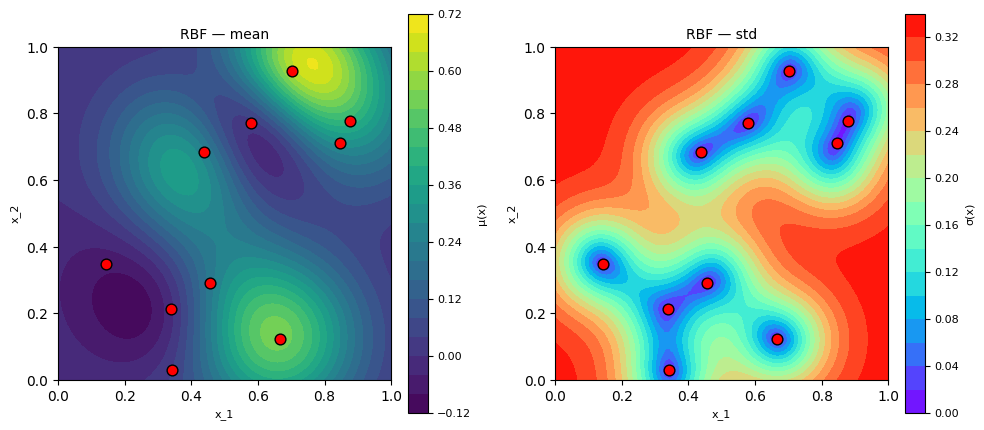

In [55]:
# Plot RBF GP: mean (left) and std (right)
# Same layout as function_1: figsize (10, 5) for 1 row × 2 cols → 5×5" per subplot; tight_layout; colorbar shrink so plot dominates
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
kernels_info = [(mu_gp_RBF, sigma_gp_RBF, "RBF")]
for i, (mu, sig, name) in enumerate(kernels_info):
    ax_mu, ax_sig = axes[0], axes[1]
    cf1 = ax_mu.contourf(X1g, X2g, mu, levels=20, cmap="viridis")
    add_colorbar(cf1, ax=ax_mu, label="μ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.85)
    ax_mu.scatter(X[:, 0], X[:, 1], c="red", s=60, edgecolors="k")
    style_axis(ax_mu, xlabel="x_1", ylabel="x_2", title=f"{name} — mean", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_mu.set_aspect("equal")
    cf2 = ax_sig.contourf(X1g, X2g, sig, levels=20, cmap="rainbow")
    add_colorbar(cf2, ax=ax_sig, label="σ(x)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, shrink=0.85)
    ax_sig.scatter(X[:, 0], X[:, 1], c="red", s=60, edgecolors="k")
    style_axis(ax_sig, xlabel="x_1", ylabel="x_2", title=f"{name} — std", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
    ax_sig.set_aspect("equal")
plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"function_2_gp_three_kernels.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path)
if IF_SHOW_PLOT:
    plt.show()  

### 3.2 The Acquisition Functions $\alpha$(x)

* Expected Improvement (EI)

* Upper Confidence Bound (UCB)

* Probability of Improvement (PI)

In [56]:
# ACQUISITION FUNCTION(s) — coefficients from "Coefficients of the Probabilistic Surrogate Models" cell (XI_EI_PI, KAPPA_UCB)

# --- EXPECTED IMPROVEMENT: EI = E[max(f(x) − f(x⁺), 0)] ---
y_best_EI = y.max()  # best observed value so far (EI baseline)
EI_RBF = expected_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_best_EI_RBF = grid_pts[np.argmax(EI_RBF)]

# --- UPPER CONFIDENCE BOUND: UCB = μ(x) + κσ(x) ---
UCB_RBF = upper_confidence_bound(mu_gp_RBF, sigma_gp_RBF, kappa=KAPPA_UCB)
x_best_UCB_RBF = grid_pts[np.argmax(UCB_RBF)]


# --- PROBABILITY OF IMPROVEMENT: PI = P(f(x) > f(x⁺)) ---
PI_RBF = probability_of_improvement(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_best_PI_RBF = grid_pts[np.argmax(PI_RBF)]

# --- THOMPSON SAMPLING: sample from posterior, then maximize the sample ---
sample_thompson_RBF = thompson_sampling_sample(mu_gp_RBF, sigma_gp_RBF)
x_thomson_RBF = grid_pts[np.argmax(sample_thompson_RBF)]

# --- ENTROPY SEARCH: proxy −σ(x) (favor reducing uncertainty) ---
ES_RBF = entropy_search(mu_gp_RBF, sigma_gp_RBF, y_best_EI, xi=XI_EI_PI)
x_entropy_RBF = grid_pts[np.argmax(ES_RBF)]


In [57]:
# Baseline: suggest next x without GP — point with highest distance to nearest observation (explore far from data).
idx_high_dist = np.argmax(min_dist.ravel())
next_x_high_dist = np.asarray(grid_pts[idx_high_dist]).ravel()
next_x_high_dist = np.clip(next_x_high_dist, 0.0, 0.999999)
next_x = next_x_high_dist
print("Suggested next x (high distance to obs):", next_x)


Suggested next x (high distance to obs): [0.       0.999999]


## 4. Illustrate the locations on the proposed query

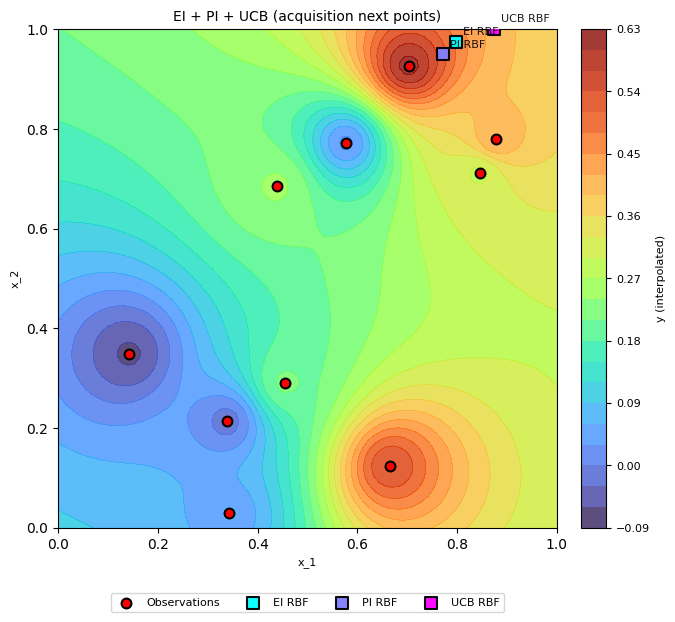

Plot saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/results/function_2_all_acquisition_points.png


In [58]:
# PLOT EI + PI + UCB (acquisition next points)

X_best_combined = np.array([x_best_EI_RBF, x_best_PI_RBF, x_best_UCB_RBF])
labels_combined = ['EI RBF', 'PI RBF', 'UCB RBF']
colors_combined = plt.cm.cool(np.linspace(0, 1, len(X_best_combined)))

fig, ax = plt.subplots(figsize=(7, 7))
cf = ax.contourf(X1g, X2g, Y_grid, levels=22, cmap="turbo", alpha=0.8)
add_colorbar(cf, ax=ax, label="y (interpolated)", font_size_axis=DEFAULT_FONT_SIZE_AXIS)
ax.scatter(X[:, 0], X[:, 1], c='red', s=50, edgecolors="k", linewidths=1.5, zorder=5, label="Observations")
for i, (pt, lbl) in enumerate(zip(X_best_combined, labels_combined)):
    ax.scatter(pt[0], pt[1], c=[colors_combined[i]], s=80, marker='s', edgecolors="k", linewidths=1.5, zorder=10, alpha=0.95, label=lbl)
    ax.annotate(lbl, (pt[0], pt[1]), xytext=(5, 5), textcoords="offset points", fontsize=DEFAULT_FONT_SIZE_AXIS, alpha=0.9, zorder=11)
style_axis(ax, xlabel="x_1", ylabel="x_2", title="EI + PI + UCB (acquisition next points)", font_size_axis=DEFAULT_FONT_SIZE_AXIS, font_size_titles=DEFAULT_FONT_SIZE_TITLES)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=DEFAULT_FONT_SIZE_AXIS, ncol=4, frameon=True)
ax.set_aspect("equal")
# Reserve bottom space for legend so tight_layout doesn't shrink the axes (legend is the usual cause of "tiny" 2D plot)
plt.tight_layout(rect=[0, 0.2, 1, 1])
if IF_SHOW_PLOT:
    plt.show()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"function_2_all_acquisition_points.{DEFAULT_EXPORT_FORMAT}"
    fig.savefig(out_path, dpi=DEFAULT_EXPORT_DPI, format=DEFAULT_EXPORT_FORMAT)
    print("Plot saved to", out_path)


## 5. Choose next query

Pick the next input to submit. **EI RBF** (Expected Improvement with RBF kernel) is the default. Alternative: `next_x_high_dist` (high distance to obs — explore unexplored regions, often useful with little data).

In [59]:
# In this cell we select the next query to submit.
# EI RBF = Expected Improvement with RBF kernel (default). Alternative: next_x_high_dist (high distance to obs).
next_x = x_best_EI_RBF  # or next_x_high_dist for high distance to obs
next_x = np.clip(np.asarray(next_x).ravel(), 0.0, 0.999999)
print(f"Next query (EI RBF): ({next_x[0]:.4f}, {next_x[1]:.4f})")

Next query (EI RBF): (0.7975, 0.9747)


## 6. Append new feedback (after portal returns)

After you submit and receive the new **(x, y)** from the portal for Function 2, paste the values below and run this cell. It appends the new point to a local dataset under `data/problems/function_2/`. The next time you run the notebook from the top, section 1 will load from this local dataset (initial + all appended points).

In [60]:
if not IF_APPEND_DATA:
    print("IF_APPEND_DATA is False; append skipped. Set IF_APPEND_DATA = True and paste portal feedback below to run.")
else:
    # Paths (use repo_root from setup cell)
    _local_dir = repo_root / "data" / "problems" / "function_2"
    assert_not_under_initial_data(_local_dir, project_root=repo_root)
    _local_inputs = _local_dir / "inputs.npy"
    _local_outputs = _local_dir / "outputs.npy"

    # Set these from the portal feedback for Function 2 (one new input and one new output)
    x_new = np.array([0.5, 0.5], dtype=np.float64)  # replace with your submitted input
    y_new = 0.0  # replace with the output returned (scalar)

    # Load current data (local if exists, else initial_data)
    if _local_inputs.exists() and _local_outputs.exists():
        X_cur = np.load(_local_inputs)
        y_cur = np.load(_local_outputs)
        if y_cur.ndim > 1:
            y_cur = y_cur.squeeze()
    else:
        X_cur, y_cur = load_function_data(function_id=2)

    # Append: one new row for inputs, one new value for outputs
    x_new = np.atleast_2d(x_new)
    X_updated = np.vstack((X_cur, x_new))
    y_updated = np.append(y_cur, y_new)

    # Save to local directory (do not overwrite read-only initial_data)
    _local_dir.mkdir(parents=True, exist_ok=True)
    np.save(_local_dir / "inputs.npy", X_updated)
    np.save(_local_dir / "outputs.npy", y_updated)
    print("Appended. Total points:", len(y_updated))
    print("Saved to", _local_dir)

IF_APPEND_DATA is False; append skipped. Set IF_APPEND_DATA = True and paste portal feedback below to run.


## 7. Save suggestion for submission

Write the chosen x to `data/submissions/` so you can upload it to the portal. **Portal format:** `x1-x2-...-xn` with **exactly six decimal places**, values in [0, 0.999999], **hyphens only, no spaces** (e.g. `0.498317-0.625531`). After you receive the new y, run section 6 (Append new feedback) to add it to your dataset, then re-run the notebook for the next round.

In [61]:
if IF_EXPORT_QUERIES:
    # Portal format: each value 0.XXXXXX (exactly 6 decimals), in [0, 0.999999], hyphen-separated, no spaces
    next_x_clip = np.clip(np.asarray(next_x, dtype=np.float64).ravel(), 0.0, 0.999999)
    portal_str = "-".join(f"{v:.6f}" for v in next_x_clip)
    out_dir = repo_root / "data" / "submissions" / "function_2"
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "next_input.npy", next_x_clip)
    (out_dir / "next_input_portal.txt").write_text(portal_str)
    print("Saved to", out_dir / "next_input.npy")
    print("Portal string (copy-paste to portal):", portal_str)
    print("Also saved to", out_dir / "next_input_portal.txt")
else:
    print("IF_EXPORT_QUERIES is False; next_input.npy not saved.")

Saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/submissions/function_2/next_input.npy
Portal string (copy-paste to portal): 0.797468-0.974684
Also saved to /Users/nikolaskarefyllidis/Desktop/60_ML:AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/submissions/function_2/next_input_portal.txt
